# Comparing O2 Rich Atmosphere with Modern Earth (Reflected Light Spectras); try to save again

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import copy
import pandas as pd
from scipy import optimize
from matplotlib import pyplot as plt
import pickle
from itertools import cycle
import matplotlib.colors as mcolors
import astropy.units as u
import astropy.constants as const

from photochem.utils import stars
import PICASO_Climate_grid_121625 as picaso_grid
import Photochem_grid_121625 as photochem_grid
import Reflected_Spectra_grid_13026 as Reflected_Spectra
from picaso.photochem import EquilibriumChemistry
import GraphsKey

import os
from pathlib import Path

current_directory = Path.cwd()
references_directory_path = "Installation&Setup_Instructions/picasofiles/reference"
PYSYN_directory_path = "Installation&Setup_Instructions/picasofiles/grp/redcat/trds"
print(os.path.join(current_directory, references_directory_path))
print(os.path.join(current_directory, PYSYN_directory_path))

os.environ['picaso_refdata']= os.path.join(current_directory, references_directory_path)
os.environ['PYSYN_CDBS']= os.path.join(current_directory, PYSYN_directory_path)


import picaso.justdoit as jdi
import picaso.justplotit as jpi

/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/reference
/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/grp/redcat/trds
/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/reference
/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/grp/redcat/trds
/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/reference/opacities/opacities_photochem_0.1_250.0_R15000.db
/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/reference
/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/grp/redcat/trds


## Function that Calculates Photochem, pressure at the bottom of a cloud, and reflected spectrum of a certain input w/ Photochem Results

In [2]:
import os

def Photochem_called(rad_plan=None, log10_planet_metallicity=None, tint=None, semi_major=None, ctoO=None, log_Kzz=None, PIC_PT=None, outputfile=None):
    # Planet Parameters
    atoms_names = ['H', 'He', 'N', 'O', 'C'] # We select a subset of the atoms in zahnle_earth.yaml (leave out Cl), remove Sulpher for faster convergence

    # Calculate the Mass of the Planet and Teq
    mass_planet_earth = picaso_grid.mass_from_radius_chen_kipping_2017(R_rearth=rad_plan)
    mass_planet = mass_planet_earth * (5.972e+24) * 1e3 # of planet, but in grams
    radius_planet = rad_plan * (6.371e+6) * 1e2 # of planet but in cm
    solar_zenith_angle = 60 # Used in Tsai et. al. (2023), in degrees
    planet_Teq = picaso_grid.calc_Teq_SUN(distance_AU=semi_major)

    # Dependent constant variables
    if os.path.exists(f'sun_flux_file_{planet_Teq}'):
        stellar_flux_file = f'sun_flux_file_{planet_Teq}'
        print(f"The stellar flux file already exists")
    else:
        wv, F = star_spectrum.solar_spectrum(Teq=planet_Teq, outputfile= f'sun_flux_file_{planet_Teq}')
        stellar_flux_file = f'sun_flux_file_{planet_Teq}'

    pressure = PIC_PT['pressure']
    temperature = PIC_PT['temperature']
    PT_list = np.array([pressure, temperature]) 

    # Test Data - This works fine.
    #with open('out_Sun_5778_initp3bar.pkl', 'rb') as file:
    #    out_reopened = pickle.load(file)
    #    pressure = out_reopened['pressure']
    #    temperature = out_reopened['temperature']
    #PT_list = np.array(pressure), np.array(temperature)
    #convergence_values = np.array([1])

    # Define P-T Profile (convert from PICASO to Photochem)
    P_extended, T_extended = photochem_grid.linear_extrapolate_TP(PT_list[0], PT_list[1]) # Extend the end to bypass BOA Error of mismatching boundary conditions.
    #P = np.flip(np.array(PT_list[0]) * (10**6)).copy()
    #T = np.flip(np.array(PT_list[1])).copy()
    P = np.flip(np.array(P_extended) * (10**6)).copy() # Convert from bars to dynes/cm^2
    T = np.flip(np.array(T_extended)).copy()
    
    # Check if numpy array is sorted (investigating error)
    sorted_P = np.flip(np.sort(P)).copy()
    unsorted_indices = np.where(P != sorted_P)[0]
    
    # Generate reaction & thermodynamic files for gas giants
    photochem_grid.zahnle_rx_and_thermo_files(
    atoms_names=atoms_names,
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml',
    remove_reaction_particles=True # For gas giants, we should always leave out reaction particles.
    )

    # Initialize ExoAtmosphereGasGiant
    # Assigns 
    pc = photochem_grid.gasgiants.EvoAtmosphereGasGiant(
        mechanism_file='photochem_rxns.yaml',
        stellar_flux_file=stellar_flux_file,
        planet_mass=mass_planet,
        planet_radius=radius_planet,
        solar_zenith_angle=solar_zenith_angle,
        thermo_file='photochem_thermo.yaml'
    )
    # Adjust convergence parameters:
    pc.var.conv_longdy = 0.03 # converges at 3% (change of mixing ratios over long time)
    pc.gdat.max_total_step = 10000 # assumes convergence after 10,000 steps
    
    pc.gdat.verbose = True # printing
    
    # Define the host star composition
    molfracs_atoms_sun = np.ones(len(pc.gdat.gas.atoms_names))*1e-10 # This is for the Sun
    comp = {
        'H' : 9.21e-01,
        'N' : 6.23e-05,
        'O' : 4.51e-04,
        'C' : 2.48e-04,
        'S' : 1.21e-05,
        'He' : 7.84e-02
    }

    tot = sum(comp.values())
    for key in comp:
        comp[key] /= tot
    for i,atom in enumerate(pc.gdat.gas.atoms_names):
        molfracs_atoms_sun[i] = comp[atom]
    
    pc.gdat.gas.molfracs_atoms_sun = molfracs_atoms_sun

    # Assume a default radius for particles 1e-5cm was default, so we increased the size but think of these in microns
    particle_radius = pc.var.particle_radius
    particle_radius[:,:] = 1e-3 #cm or 10 microns
    pc.var.particle_radius = particle_radius

    # Assumed Kzz (cm^2/s) in Tsai et al. (2023)
    Kzz_zero_grid = np.ones(P.shape[0])
    Kzz = Kzz_zero_grid*(10**log_Kzz) #Note Kzz_fac was meant to be the power of 10 since we are in log10 space

    # Initialize the PT based on chemical equilibrium 
    pc.gdat.BOA_pressure_factor = 3
    pc.initialize_to_climate_equilibrium_PT(P, T, Kzz, 10**log10_planet_metallicity, ctoO)
    
    # Integrate to steady state
    converged = pc.find_steady_state()

    # Check if the model converged after 10,000 steps
    if not converged:
        assert pc.gdat.total_step_counter > pc.gdat.max_total_step - 10
        
    sol_raw = pc.return_atmosphere()
    soleq_raw = pc.return_atmosphere(equilibrium=True)

    # Call the interpolation of the grid 
    sol = photochem_grid.interpolate_photochem_result_to_nlayers(out=sol_raw, nlayers=100)
    soleq = photochem_grid.interpolate_photochem_result_to_nlayers(out=soleq_raw, nlayers=100)
    #convergence_values = np.array([convergence_values[0] for _ in range(len(sol['pressure']))])
    #converged = np.array([converged for _ in range(len(sol['pressure']))])

    # Print out the lengths of arrays: Save the size of the grid for future reference.

    print(f"This is for the input value of planet radius:{rad_plan}, metal:{float(log10_planet_metallicity)}, tint:{tint}, semi major:{semi_major}, ctoO: {ctoO}, log_Kzz: {log_Kzz}")
    
    #for key, value in sol.items():
    #    if isinstance(value, np.ndarray):  # Check if the value is a list (or array)
    #        print(f"The array for sol's '{key}' has a length of: {len(value)}")
    #    else:
    #        print(f"The value for sol's '{key}' is not an array.")

    #for key, value in soleq.items():
    #    if isinstance(value, np.ndarray):  # Check if the value is a list (or array)
    #        print(f"The array for soleq's '{key}' has a length of: {len(value)}, Length of pressure: {len(P)}")
    #    else:
    #        print(f"The value for soleq's '{key}' is not an array.")

    # Add nan's to fit the grid if underestimated, and make sure list goes from largest to smallest.

    if outputfile == None:
        return sol, soleq, pc

    else:
        with open(f'sol_{outputfile}.pkl', 'wb') as f:
            pickle.dump(sol, f)
        with open(f'soleq_{outputfile}.pkl', 'wb') as f:
            pickle.dump(soleq, f)
        return sol, soleq, pc
        

In [3]:
def find_pbot(sol=None, solaer=None, tol=0.9):

    """
    Parameters:
    pressures: ndarray
        Pressure at each atmospheric layer in dynes/cm^2
    H2Oaer: ndarray
        Mixing ratio of H2O aerosols.
    tol: float, optional
        The threshold value for which we define the beginning of the cloud, 
        by default 1e-4. 

    Returns:
    P_bottom: float
        The cloud bottom pressure in dynes/cm^2
        
    """

    pressure = sol['pressure']
    H2Oaer = solaer['H2Oaer']

    # There is no water cloud in the model, so we return None
    # For the cloud bottom of pressure

    if np.max(H2Oaer) < 1e-20:
        return None

    # Normalize so that max value is 1
    H2Oaer_normalized = H2Oaer/np.max(H2Oaer)

    # loop from bottom to top of atmosphere, cloud bottom pressure
    # defined as the index level where the normalized cloud mixing ratio
    # exeeds tol .

    ind = None
    
    for i, val in enumerate(H2Oaer_normalized):
        if val > tol:
            ind = i
            break

    if ind is None:
        raise Exception('A problem happened when trying to find the bottom of the cloud.')

    # Bottom of the cloud
    pbot = pressure[ind]

    return pbot

In [4]:
def reflected_spectrum_planet_Sun(rad_plan=None, planet_metal=None, tint=None, semi_major=None, ctoO=None, Kzz=None, phase_angle=None, sol_path=None, soleq_path=None, Photochem_file=False,atmosphere_kwargs={}):

    """
    This finds the reflected spectra of a planet similar to K218b around a Sun.

    Parameters:
    rad_plan: float
        This is the radius of the planet in units of Earth radii.
    planet_metal: float
        This is the planet's metallicity in units of log10 x Solar metallicity.
    tint: float
        This is the planet's internal temperature in Kelvin.
    semi_major: float
        This is the semi major axis of your planet's orbit in units of AU.
    ctoO: float
        This is the carbon to oxygen ratio of your planet's atmosphere in units of xSolar c/o.
    Kzz: float
        This is the eddy diffusion coefficient in logspace (i.e. the power of 10) in cm/s^2.
    phase_angle: float
        This is the phase of orbit the planet is in relative to its star and the observer (i.e. how illuminated it is), units of radians.
    Photochem_file: string
        This is the path to the Photochem grid you would like to pull composition information from.
    atmosphere_kwargs: dict 'exclude_mol': value where value is a string
        If left empty, all molecules are included, but can limit how many molecules are calculated. 

    Results: IDK for sure though
    wno: grid of 150 points
        ???
    fpfs: grid of 150 points
        This is the relative flux of the planet and star (fp/fs). 
    alb: grid of 150 points
        ???
    np.array(clouds): grid of 150 points
        This is a grid of whether or not a cloud was used to make the reflective spectra using the binary equivalent to booleans (True=1, False=0).
        
    """

    current_directory = Path.cwd()
    opacity_file_path = "Installation&Setup_Instructions/picasofiles/reference/opacities/opacities_photochem_0.1_250.0_R15000.db"  
    opacity_path=os.path.join(current_directory, opacity_file_path)
    print(opacity_path)
    opacity = jdi.opannection(filename_db=opacity_path, wave_range=[0.1,2.5])

    planet_metal = float(planet_metal)
    
    start_case = jdi.inputs()

    # Then calculate the composition from the TP profile
    class planet:
        
        planet_radius = (rad_plan*6.371e+6*u.m) # in meters
        planet_mass = picaso_grid.mass_from_radius_chen_kipping_2017(R_rearth=rad_plan)*(5.972e+24) # in kg
        planet_Teq = picaso_grid.calc_Teq_SUN(distance_AU=semi_major) # Equilibrium temp (K)
        planet_grav = (const.G * (planet_mass)) / ((planet_radius)**2) # of K2-18b in m/s^2
        planet_ctoO = ctoO # in xSolar

    class Sun:
        
        stellar_radius = 1 # Solar radii
        stellar_Teff = 5778 # K
        stellar_metal = 0.0 # log10(metallicity)
        stellar_logg = 4.4 # log10(gravity), in cgs units

    solar_zenith_angle = 60 # Used in Tsai et al. (2023)
        
    # Star and Planet Parameters (Stay the Same & Should Match Photochem & PICASO)
    start_case.phase_angle(phase_angle, num_tangle=8, num_gangle=8) #radians, using default here

    jupiter_mass = const.M_jup.value # in kg
    jupiter_radius = 69911e+3 # in m
    start_case.gravity(gravity=planet.planet_grav, gravity_unit=jdi.u.Unit('m/(s**2)'), radius=(planet.planet_radius.value)/jupiter_radius, radius_unit=jdi.u.Unit('R_jup'), mass=(planet.planet_mass)/jupiter_mass, mass_unit=jdi.u.Unit('M_jup'))
    
    # star temperature, metallicity, gravity, and opacity (default opacity is opacity.db in the reference folder)
    start_case.star(opannection=opacity, temp=Sun.stellar_Teff, logg=Sun.stellar_logg, semi_major=semi_major, metal=Sun.stellar_metal, radius=Sun.stellar_radius, radius_unit=jdi.u.R_sun, semi_major_unit=jdi.u.au)

    # Match Photochemical Files
    if Photochem_file is not True:
        sol_dict, soleq_dict, PT_list, convergence_PC, convergence_TP = Reflected_Spectra.find_Photochem_match(filename=Photochem_file, rad_plan=rad_plan, log10_planet_metallicity=planet_metal, tint=tint, semi_major=semi_major, ctoO=ctoO,Kzz=Kzz)

    elif Photochem_file is True:
        with open(sol_path, 'rb') as file:
            sol_dict = pickle.load(file)
        with open(soleq_path, 'rb') as file:
            soleq_dict = pickle.load(file)
    
            
    # Determine Planet Atmosphere & Composition

    atm, sol_dict_aer = Reflected_Spectra.make_picaso_atm(sol_dict) # Converted Pressure of Photochem, in dynes/cm^2, back to bars and flip all arrays before placing into PICASO
    print(type(atm['pressure']))
    print(f'Length of pressure vs other element: {len(atm['pressure'])} vs {len(atm['He'])}')

    # Limit atmosphere to pressures 1000 bars and below.

    atm_filtered = {}
    
    # Threshold value
    threshold = 1000
    
    # Filter the list for a specific key (e.g., 'key1')
    # Convert list to NumPy array for efficient filtering
    arr = np.array(atm['temperature'])
    
    # Use boolean indexing to filter values less than the threshold
    filtered_arr = arr[arr < threshold]
    
    # Update the dictionary (optional: convert back to list)
    atm_filtered['temperature'] = filtered_arr # or keep as a NumPy array: data['key1'] = filtered_arr
    atm_filtered['pressure'] = atm['pressure'][:len(atm_filtered['temperature'])] # filter temperature by index

   # Define keys to ignore
    exclude = {'pressure', 'temperature'}
    
    for key, value in atm.items():
        if key not in exclude:
            atm_filtered[key] = value[:len(atm_filtered['temperature'])]
            #print(f'updated with {key}: {atm_filtered}')
        
    
    #print(f"Original dictionary: {atm.keys()}")
    #print(f"Filtered 'pressure' values (below {threshold}): {len(atm_filtered['pressure'])}, then temperature should be the same length as new pressure: {len(atm_filtered['temperature'])}")
    #print(f"Quick check with PT association of old and new dictionaries: filtered pres: {atm_filtered['pressure'][5]}, filtered temp: {atm_filtered['temperature'][5]}, original pres: {atm['pressure'][5]}, original temp: {atm['temperature'][5]}")

    df_atmo = jdi.pd.DataFrame(atm_filtered)

    print(df_atmo)
    plt.gca().invert_yaxis()
    plt.semilogy(df_atmo['temperature'], df_atmo['pressure'], ls='-', c='red') 
    plt.semilogy(atm['temperature'], atm['pressure'], ls='--', c='blue')

    # 4. Customize and display
    plt.title("Filtered PT Profile")
    plt.xlabel("Temperature in K")
    plt.ylabel("Pressure in bars")
    plt.legend() # Displays the labels
    plt.show()

    if 'exclude_mol' in atmosphere_kwargs:
        sp = atmosphere_kwargs['exclude_mol'][0]
        if sp in df_atmo:
            df_atmo[sp] *= 0
            
    start_case.atmosphere(df = df_atmo) 
    df_cldfree = start_case.spectrum(opacity, calculation='reflected', full_output=True)
    wno_cldfree, alb_cldfree, fpfs_cldfree = df_cldfree['wavenumber'], df_cldfree['albedo'], df_cldfree['fpfs_reflected']
    _, alb_cldfree_grid = jdi.mean_regrid(wno_cldfree, alb_cldfree, R=150)
    wno_cldfree_grid, fpfs_cldfree_grid = jdi.mean_regrid(wno_cldfree, fpfs_cldfree, R=150)

    print(f'This is the length of the grids created: {len(wno_cldfree_grid)}, {len(fpfs_cldfree_grid)}')

    # Determine Whether to Add Clouds or Not?

    if "H2Oaer" in sol_dict_aer:
        # What if we added Grey Earth-like Clouds?
        
        # Calculate pbot:
        pbot = find_pbot(sol = atm, solaer=sol_dict_aer)

        if pbot is not None:
            print(f'pbot was calculated, there is H2Oaer and a cloud was implemented')
            logpbot = np.log10(pbot)
        
            # Calculate logdp:
            ptop_earth = 0.6
            pbot_earth = 0.7
            logdp = np.log10(pbot_earth) - np.log10(ptop_earth)  
    
            # Default opd (optical depth), w0 (single scattering albedo), g0 (asymmetry parameter)
            start_case.clouds(w0=[0.99], g0=[0.85], 
                              p = [logpbot], dp = [logdp], opd=[10])
            # Cloud spectrum
            df_cld = start_case.spectrum(opacity,full_output=True)
            
            # Average the two spectra - This differs between Calculating Earth Reflected Spectra 
            wno_c, alb_c, fpfs_c, albedo_c = df_cld['wavenumber'],df_cld['albedo'],df_cld['fpfs_reflected'], df_cld['albedo']
            _, alb = jdi.mean_regrid(wno_cldfree, 0.5*alb_cldfree+0.5*albedo_c,R=150)
            wno, fpfs = jdi.mean_regrid(wno_cldfree, 0.5*fpfs_cldfree+0.5*fpfs_c,R=150)

            # Match the length of the clouds array with the length of wno or alb (fpfs is different length)
            clouds = [1] * len(wno)

            return wno, fpfs, alb, np.array(clouds)

        else:
            print(f'pbot is empty, so no cloud is implemented')
            wno = wno_cldfree_grid.copy()
            alb = alb_cldfree_grid.copy()
            fpfs = fpfs_cldfree_grid.copy()

            # Match the length of the clouds array with the length of wno or alb (fpfs is different length)
            clouds = [0] * len(wno)

            print(f'This is the length of the values I want to save: wno {len(wno)}, alb {len(alb)}, fpfs {len(fpfs)}, clouds {len(clouds)}')

            return wno, fpfs, alb, np.array(clouds)

    else:
        print(f'H2Oaer is not in solutions')
        wno = wno_cldfree_grid.copy()
        alb = alb_cldfree_grid.copy()
        fpfs = fpfs_cldfree_grid.copy()
        print(f'For the inputs: {rad_plan}, {planet_metal}, {tint}, {semi_major}, {ctoO}, {Kzz}, {phase_angle}, The length should match: wno - {len(wno)}, alb - {len(alb)}, fpfs - {len(fpfs)}')
        
        # Match the length of the clouds array with the length of wno or alb (fpfs is different length)
        clouds = [0] * len(wno) # This means that there are no clouds

        return wno, fpfs, alb, np.array(clouds)

In [5]:
def plot_photochem_model_with_cloud(sol=None, soleq=None):

    """
    Parameters:
        TBD
    """
    solaer_dict = {}

    for key, value in sol.items():
        if key.endswith('aer'):
            solaer_dict[key] = value
            
    print(solaer_dict.keys())
        
    pbot = find_pbot(sol=sol, solaer=solaer_dict)
    
    # Plot the Composition from Photochem
    fig, ax1 = plt.subplots(1,1,figsize=[8,6])
    species = ['CO2','CH4','H2O','CO','NH3','H2','HCN', 'O', 'O2', 'O3', 'OH', 'N2']
    species_aer = ['H2Oaer']

    custom_colors = ['red', 'green', 'blue', 'orange', 'purple', 'grey', 'yellow', 'black', 'magenta', 'cyan', 'pink', 'limegreen']
    custom_colors_2 = ['skyblue']

    index_sol = 0
    index_soleq = 0
    
    for i,sp in enumerate(species):
        ax1.plot(sol[sp],np.array(sol['pressure'])/1e6, c=custom_colors[index_sol], label=sp)
        index_sol += 1

    for i, sp in enumerate(species_aer):
        ax1.plot(sol[sp], np.array(sol['pressure'])/1e6, c=custom_colors_2[index_soleq], label=sp)
        index_soleq += 1
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-5,1)
    ax1.set_ylim(1000,1e-7)
    ax1.grid(alpha=0.4)
    ax1.set_xlabel('Mixing Ratio', fontsize=16)
    ax1.set_ylabel('Pressure (bars)', fontsize=16)
    ax1.set_yticks(10.0**np.arange(-6,2))
    ax1.tick_params(axis='x', labelsize=16) 
    ax1.tick_params(axis='y', labelsize=16)
    
    
    # Thickness of the box cloud
    ptop_earth = 0.6
    pbot_earth = 0.7
    logdp = np.log10(pbot_earth) - np.log10(ptop_earth)
    
    # Outline of the box cloud
    x_values = np.logspace(-8, 0, 10)
    y_values_bot = [pbot/10**6] * len(x_values)
    y_values_top = [(pbot/10**6) - ((10**(np.log10(pbot/10**6) - logdp)))] * len(x_values)
    
    ax1.plot(x_values, y_values_bot, c='black', ls='--', label='Cloud Bottom')
    ax1.plot(x_values, y_values_top, c='black', ls='--', label='Cloud Top')
    ax1.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
     
    ax2 = ax1.twiny()
    ax2.set_xlim(0, 3000)
    ax2.set_xlabel('Temperature (K)', fontsize=16)
    ax2.tick_params(axis='x', labelsize=16)
    ax2.plot(sol['temperature'], (sol['pressure']/(1e6)), c='blue', ls='--',label='Photochem PT Profile')
    plt.legend()
    
    plt.title('K2-18b Around Sun (G-Star)', fontsize=20)
    plt.tight_layout()
    plt.savefig('K218b_Sun_ReflectedSpectra_Clds.png')
    
    plt.show()


## Example Application of O2 Rich K218b
Parameters:
- planet radius: 2.61x Earth
- **metallicity: 3.5x (logspace) x solar (~3000x solar metallicity)**
- tint: 155K
- semi major in AU: 1 AU
- **ctoO_solar: 0.01 x solar c/o ratio**

### Load/Solve for PICASO file

In [6]:
file_path = "out_3.5m_0.01co.pkl"
with open(file_path, 'rb') as file:
    data_35m_001co = pickle.load(file)
    print(data_35m_001co)

{'pressure': array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
       2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
       6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
       1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
       3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
       1.00000000e-04, 1.25892541e-04, 1.58489319e-04, 1.99526231e-04,
       2.51188643e-04, 3.16227766e-04, 3.98107171e-04, 5.01187234e-04,
       6.30957344e-04, 7.94328235e-04, 1.00000000e-03, 1.25892541e-03,
       1.58489319e-03, 1.99526231e-03, 2.51188643e-03, 3.16227766e-03,
       3.98107171e-03, 5.01187234e-03, 6.30957344e-03, 7.94328235e-03,
       1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
       2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
       6.30957344e-02, 7.94328235e-02, 1.00000000e-01, 1.25892541e-01,
       1.58489319e-01, 1.99526231e-01, 2.51188643e-01, 3.1622776

### Load/Solve for Photochem Profile

In [7]:
sol_file_path = "sol_2.61_3.5_155_1_0.01_5.pkl"
soleq_file_path = "soleq_2.61_3.5_155_1_0.01_5.pkl"

with open(sol_file_path, 'rb') as file:
    photochem_data_35m_001co_sol = pickle.load(file)
    print(photochem_data_35m_001co_sol.keys())

with open(soleq_file_path, 'rb') as file:
    photochem_data_35m_001co_soleq = pickle.load(file)
    print(photochem_data_35m_001co_soleq.keys())

dict_keys(['pressure', 'temperature', 'Kzz', 'H2Oaer', 'CO2aer', 'NH3aer', 'N2Oaer', 'C2H2aer', 'C2H4aer', 'C2H6aer', 'CH3CNaer', 'HCCCNaer', 'HCNaer', 'CH4aer', 'He', 'H', 'H2', 'H2O', 'OH', 'O', 'O2', 'CO', 'CO2', 'HCO', 'H2CO', 'C', 'CH', 'CH2', 'CH3', 'CH4', 'CN', 'HCN', 'N', 'N2', 'NH', 'NH2', 'NH3', 'C2', 'C2H', 'C2H2', 'C2H4', 'NO', 'HNO', 'HO2', 'HNCO', 'N2O', 'H2O2', 'O3', 'NO2', 'NO3', 'HNO2', 'HNO3', 'N2H4', 'C2H6', 'CH3OH', 'CH2CO', 'CH3CHO', 'C3H4', 'C3H6', 'C4H2', 'C4H4', 'C2H3', 'C2H5', 'NCO', '1CH2', 'HCCO', 'NNH', 'CH3O', 'H2COH', 'H2CN', 'N2H2', 'C4H', 'HCNOH', 'C2H2OH', 'CH3CO', 'CH2CHO', 'C2H3OH', 'C2H4OH', 'CH3O2', 'O1D', 'N2H3', 'NH2CO', 'C4H3', 'CH2N2', 'N2D', 'CH2CN', 'CH3CN', 'HCCCN'])
dict_keys(['pressure', 'temperature', 'Kzz', 'He', 'H', 'H2', 'H2O', 'OH', 'O', 'O2', 'CO', 'CO2', 'HCO', 'H2CO', 'C', 'CH', 'CH2', 'CH3', 'CH4', 'CN', 'HCN', 'N', 'N2', 'NH', 'NH2', 'NH3', 'C2', 'C2H', 'C2H2', 'C2H4', 'NO', 'HNO', 'HO2', 'HNCO', 'N2O', 'H2O2', 'O3', 'NO2', 'NO3'

In [8]:
rad_plan = 2.61
log10_metal = 3.5
tint = 155
semi_major = 1
ctoO = 0.01
Kzz = 5

# Save to file above!
#sol, soleq, pc = Photochem_called(rad_plan=rad_plan, log10_planet_metallicity=log10_metal, tint=tint, semi_major=semi_major, ctoO=ctoO, log_Kzz=Kzz, PIC_PT=data_35m_001co, outputfile=f'{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}')

### Plot the PT/Photochem Profile with Clouds (or without):

dict_keys(['H2Oaer', 'CO2aer', 'NH3aer', 'N2Oaer', 'C2H2aer', 'C2H4aer', 'C2H6aer', 'CH3CNaer', 'HCCCNaer', 'HCNaer', 'CH4aer'])


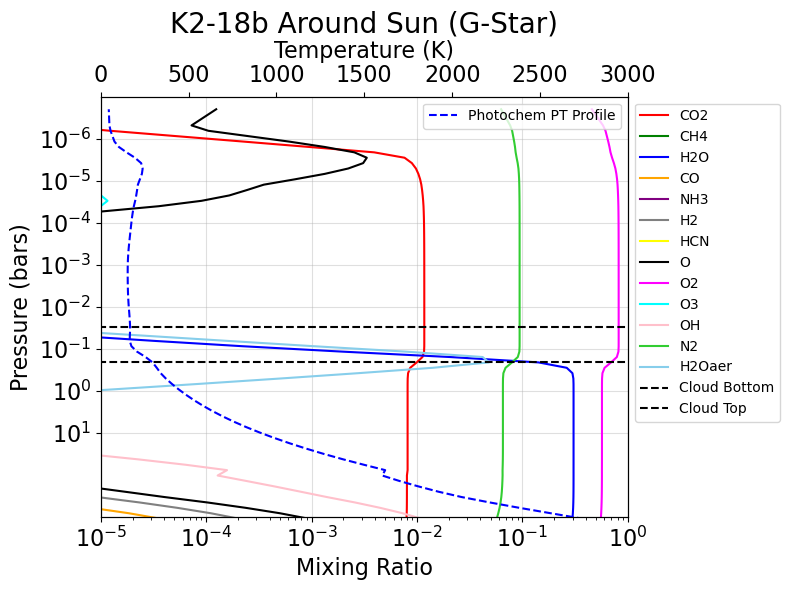

In [9]:
plot_photochem_model_with_cloud(sol=photochem_data_35m_001co_sol, soleq=photochem_data_35m_001co_soleq)

### Calculating Reflected Spectra

/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/reference/opacities/opacities_photochem_0.1_250.0_R15000.db
<class 'numpy.ndarray'>
Length of pressure vs other element: 100 vs 100
    temperature      pressure       Kzz        He             H            H2  \
0     45.427375  2.000052e-07  100000.0  0.480894  3.364975e-08  6.838606e-08   
1     46.670590  2.687284e-07  100000.0  0.426367  2.769776e-08  5.788454e-08   
2     47.913805  3.610654e-07  100000.0  0.378022  2.279857e-08  4.899566e-08   
3     49.157020  4.851301e-07  100000.0  0.335159  1.876595e-08  4.147177e-08   
4     55.534162  6.518243e-07  100000.0  0.304053  2.731966e-08  3.633651e-08   
..          ...           ...       ...       ...           ...           ...   
57   692.679835  4.097915e+00  100000.0  0.052044  2.484444e-23  2.235201e-17   
58   757.047255  5.505988e+00  100000.0  0.052044  5.998191e-21  1.070003e-15   
59   827.121844  7.397885e+00  100000.0  0

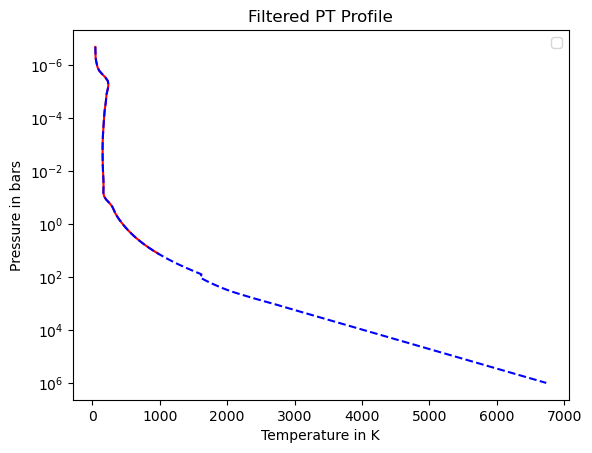

This is the length of the grids created: 483, 483
pbot was calculated, there is H2Oaer and a cloud was implemented


In [10]:
rad_plan = 2.61
log10_metal = 3.5
tint = 155
semi_major = 1
ctoO = 0.01
Kzz = 5
sol_path = f'sol_{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}.pkl'
soleq_path = f'soleq_{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}.pkl'
phase_angle = 0

wno, fpfs, alb, clouds = reflected_spectrum_planet_Sun(rad_plan=rad_plan, planet_metal=log10_metal, tint=tint, semi_major=semi_major, ctoO=ctoO, Kzz=Kzz, phase_angle=phase_angle, sol_path=sol_path, soleq_path=soleq_path, Photochem_file=True)

### Load the Earth Spectra's (either singular or a dictionary of different phases):

In [15]:
# Load up the earth spectra's
with open('archean_earth_res.pkl', 'rb') as file:
    res_archean_earth = pickle.load(file)

res_archean_earth

with open('modern_earth_res.pkl', 'rb') as file:
    res_modern_earth = pickle.load(file)

res_modern_earth

with open('earth_diff_phases.pkl', 'rb') as file:
    res_earth_diff_phases = pickle.load(file)
    print(res_earth_diff_phases.keys())

wv_archean = res_archean_earth['all'][0]
fpfs_archean = res_archean_earth['all'][1]
alb_archean = res_archean_earth['all'][2]
wv_modern = res_modern_earth['all'][0]
fpfs_modern = res_modern_earth['all'][1]
alb_modern = res_modern_earth['all'][2]

dict_keys(['Archean_wv_0', 'Archean_fpfs_0', 'Archean_alb_0', 'Archean_wv_0.17453293', 'Archean_fpfs_0.17453293', 'Archean_alb_0.17453293', 'Archean_wv_0.34906585', 'Archean_fpfs_0.34906585', 'Archean_alb_0.34906585', 'Archean_wv_0.52359878', 'Archean_fpfs_0.52359878', 'Archean_alb_0.52359878', 'Archean_wv_0.6981317', 'Archean_fpfs_0.6981317', 'Archean_alb_0.6981317', 'Archean_wv_0.87266463', 'Archean_fpfs_0.87266463', 'Archean_alb_0.87266463', 'Archean_wv_1.04719755', 'Archean_fpfs_1.04719755', 'Archean_alb_1.04719755', 'Archean_wv_1.22173048', 'Archean_fpfs_1.22173048', 'Archean_alb_1.22173048', 'Archean_wv_1.3962634', 'Archean_fpfs_1.3962634', 'Archean_alb_1.3962634', 'Archean_wv_1.57079633', 'Archean_fpfs_1.57079633', 'Archean_alb_1.57079633', 'Archean_wv_1.74532925', 'Archean_fpfs_1.74532925', 'Archean_alb_1.74532925', 'Archean_wv_1.91986218', 'Archean_fpfs_1.91986218', 'Archean_alb_1.91986218', 'Archean_wv_2.0943951', 'Archean_fpfs_2.0943951', 'Archean_alb_2.0943951', 'Archean_wv

### Plot the Reflected Light Spectra
- Just compared to 0 phase case of Modern/Archean Earth Spectra
- And compared to all phases of the closest tye of Earth to show how much of a match some of the features can be

2.61_0.5_155_1.04_1_5


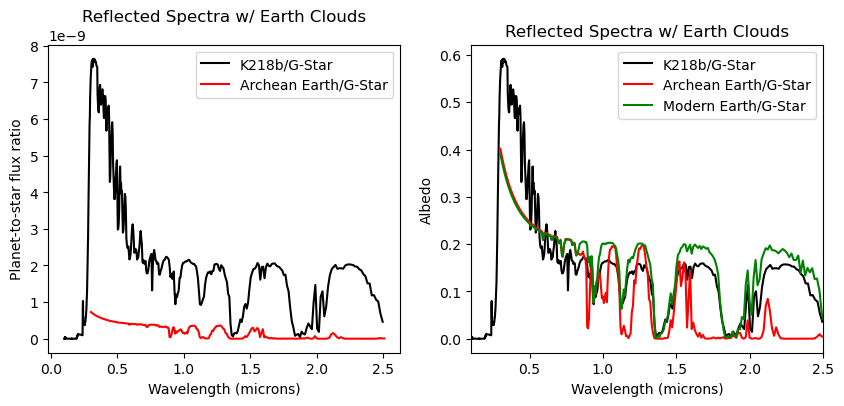

In [84]:
wno_earth = wv_archean
fpfs_earth = fpfs_archean
alb_earth = alb_archean

print(f'{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
ax1.plot(1e4/wno, fpfs, c='k', lw=1.5, label='K218b/G-Star')
ax1.plot(1e4/wno_earth, fpfs_earth, c='red', lw=1.5, label='Archean Earth/G-Star')
#ax1.set_xlim(0.3,10)
#ax1.set_ylim(0e-10,10e-10)
ax1.set_ylabel('Planet-to-star flux ratio')
ax1.set_xlabel('Wavelength (microns)')
ax1.set_title('Reflected Spectra w/ Earth Clouds')
ax1.legend()

ax2.plot(1e4/wno, alb, c='k', lw=1.5, label='K218b/G-Star')
ax2.plot(1e4/wno_earth, alb_earth, c='red', lw=1.5, label='Archean Earth/G-Star')
ax2.plot(1e4/wv_modern, alb_modern, c='green', lw=1.5, label='Modern Earth/G-Star')
ax2.set_xlim(0.1,2.5)
#ax2.set_ylim(0e-10,10e-9)
ax2.set_ylabel('Albedo')
ax2.set_xlabel('Wavelength (microns)')
ax2.set_title('Reflected Spectra w/ Earth Clouds')
ax2.legend()

#plt.savefig('Earth_K218b_clouds_RS.pdf',bbox_inches='tight')

#plt.savefig('Earth_K218b_clouds_RS_zoomedin.pdf',bbox_inches='tight')
plt.show()

In [23]:
with open('earth_diff_phases.pkl', 'rb') as file:
    earth_dict = pickle.load(file)
    print(earth_dict.keys())

dict_keys(['Archean_wv_0', 'Archean_fpfs_0', 'Archean_alb_0', 'Archean_wv_0.17453293', 'Archean_fpfs_0.17453293', 'Archean_alb_0.17453293', 'Archean_wv_0.34906585', 'Archean_fpfs_0.34906585', 'Archean_alb_0.34906585', 'Archean_wv_0.52359878', 'Archean_fpfs_0.52359878', 'Archean_alb_0.52359878', 'Archean_wv_0.6981317', 'Archean_fpfs_0.6981317', 'Archean_alb_0.6981317', 'Archean_wv_0.87266463', 'Archean_fpfs_0.87266463', 'Archean_alb_0.87266463', 'Archean_wv_1.04719755', 'Archean_fpfs_1.04719755', 'Archean_alb_1.04719755', 'Archean_wv_1.22173048', 'Archean_fpfs_1.22173048', 'Archean_alb_1.22173048', 'Archean_wv_1.3962634', 'Archean_fpfs_1.3962634', 'Archean_alb_1.3962634', 'Archean_wv_1.57079633', 'Archean_fpfs_1.57079633', 'Archean_alb_1.57079633', 'Archean_wv_1.74532925', 'Archean_fpfs_1.74532925', 'Archean_alb_1.74532925', 'Archean_wv_1.91986218', 'Archean_fpfs_1.91986218', 'Archean_alb_1.91986218', 'Archean_wv_2.0943951', 'Archean_fpfs_2.0943951', 'Archean_alb_2.0943951', 'Archean_wv

[1.59789473e-03 2.36511637e-03 5.11049284e-03 1.25147010e-03
 1.78774156e-04 1.44110599e-04 1.02651090e-04 6.48558539e-06
 4.61017631e-06 6.71070639e-06 3.89964129e-06 6.70894311e-06
 3.50556127e-05 4.42591523e-06 6.36139540e-06 8.25329522e-06
 7.48791002e-06 1.53051202e-05 2.98216265e-04 1.44789766e-03
 9.55115295e-03 2.68368866e-02 7.11706767e-03 2.79367552e-02
 7.24861283e-02 9.55060461e-02 7.82695349e-02 1.74764802e-02
 1.72743564e-03 3.52084220e-05 4.93300219e-05 1.98881942e-03
 3.90763602e-04 9.99681993e-06 2.93396087e-03 3.27803239e-02
 2.68661363e-03 1.83941383e-05 4.75478661e-04 4.15071219e-03
 1.96783014e-03 1.21929697e-04 3.48501564e-04 3.74422284e-04
 8.57873180e-05 7.95903279e-05 7.34462661e-05 6.91348257e-05
 7.73561138e-04 2.14444397e-03 1.36853699e-03 3.69159034e-03
 8.96540389e-04 2.81729097e-03 2.51916803e-03 1.79462012e-03
 1.54317709e-04 1.85691195e-03 6.89374646e-05 1.62588551e-03
 6.54866347e-03 1.54336064e-03 8.60749844e-03 3.62729881e-03
 6.90073965e-03 1.612646

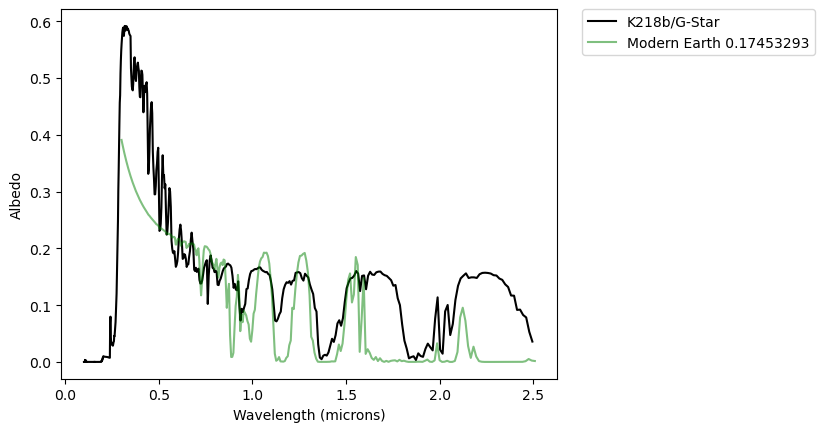

In [60]:
phase_angle_list = [0, 0.17453293, 0.34906585, 0.52359878, 0.6981317 , 
                    0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633,
                    1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095,
                    2.61799388, 2.7925268 , 2.96705973, 3.14159265]
phase_earth = phase_angle_list[:-1]

wv_archean_list = []    
fpfs_archean_list = []
alb_archean_list = []
wv_modern_list = []
fpfs_modern_list = []
alb_modern_list = []

with open('earth_diff_phases.pkl', 'rb') as file:
    earth_dict = pickle.load(file)
    for phase in phase_earth:
        for key in list(earth_dict.keys()):
            #print(f'phase: {phase}, key: {key}')
            if key.endswith(f'_{phase}'):
                if key.startswith(f'Archean_wv_'):
                    wv_archean = earth_dict[key]
                    wv_archean_list.append(wv_archean)
                if key.startswith(f'Archean_fpfs_'):
                    fpfs_archean = earth_dict[key]
                    fpfs_archean_list.append(fpfs_archean)
                if key.startswith(f'Archean_alb_'):
                    alb_archean = earth_dict[key]
                    alb_archean_list.append(alb_archean)
                if key.startswith(f'Modern_wv_'):
                    wv_modern = earth_dict[key]
                    wv_modern_list.append(wv_modern)
                if key.startswith(f'Modern_fpfs_'):
                    fpfs_modern = earth_dict[key]
                    fpfs_modern_list.append(fpfs_modern)
                if key.startswith(f'Modern_alb_'):
                    alb_modern = earth_dict[key]
                    alb_modern_list.append(alb_archean)

print(alb_modern_list[1], alb_archean_list[1])
index_earth_full = np.linspace(0, len(phase_earth) - 1, len(phase_earth), dtype='int')
index_earth = index_earth_full[1:2]
        
# Define a list of colors or use a color cycle
colors = ['green', 'blue', 'orange']
color_cycler = cycle(colors) # For cycling through colors if more data sets than colors

fig, ax = plt.subplots()
ax.plot(1e4/wno, alb, c='k', lw=1.5, label='K218b/G-Star')
ax.set_ylabel('Albedo')
ax.set_xlabel('Wavelength (microns)')
for index_earth_val in index_earth:  
    ax.plot(1e4/wv_modern_list[index_earth_val], alb_modern_list[index_earth_val], c=next(color_cycler), lw=1.5, alpha=0.5, label=f'Modern Earth {phase_earth[index_earth_val]}')
    #ax.plot(1e4/wv_archean_list[index_earth_val], alb_earth[index_earth_val], c=next(color_cycler), lw=1.5, alpha=0.5, label=f'Archean Earth {phase_earth[index_earth_val]}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Calculate the same plots but for the metallicity = 1000x solar case
**Parameters**:
- planet radius: 2.61x Earth
- **metallicity: 3x (logspace) x solar (~1000x solar metallicity)**
- tint: 155K
- semi major in AU: 1 AU
- **ctoO_solar: 0.01 x solar c/o ratio**

In [36]:
sol_file_path = "sol_2.61_3_155_1_0.01_5.pkl"
soleq_file_path = "soleq_2.61_3_155_1_0.01_5.pkl"

with open(sol_file_path, 'rb') as file:
    photochem_data_1000m_001co_sol = pickle.load(file)
    print(photochem_data_1000m_001co_sol.keys())

with open(soleq_file_path, 'rb') as file:
    photochem_data_1000m_001co_soleq = pickle.load(file)
    print(photochem_data_1000m_001co_soleq.keys())

dict_keys(['pressure', 'temperature', 'Kzz', 'H2Oaer', 'CO2aer', 'NH3aer', 'N2Oaer', 'C2H2aer', 'C2H4aer', 'C2H6aer', 'CH3CNaer', 'HCCCNaer', 'HCNaer', 'CH4aer', 'He', 'H', 'H2', 'H2O', 'OH', 'O', 'O2', 'CO', 'CO2', 'HCO', 'H2CO', 'C', 'CH', 'CH2', 'CH3', 'CH4', 'CN', 'HCN', 'N', 'N2', 'NH', 'NH2', 'NH3', 'C2', 'C2H', 'C2H2', 'C2H4', 'NO', 'HNO', 'HO2', 'HNCO', 'N2O', 'H2O2', 'O3', 'NO2', 'NO3', 'HNO2', 'HNO3', 'N2H4', 'C2H6', 'CH3OH', 'CH2CO', 'CH3CHO', 'C3H4', 'C3H6', 'C4H2', 'C4H4', 'C2H3', 'C2H5', 'NCO', '1CH2', 'HCCO', 'NNH', 'CH3O', 'H2COH', 'H2CN', 'N2H2', 'C4H', 'HCNOH', 'C2H2OH', 'CH3CO', 'CH2CHO', 'C2H3OH', 'C2H4OH', 'CH3O2', 'O1D', 'N2H3', 'NH2CO', 'C4H3', 'CH2N2', 'N2D', 'CH2CN', 'CH3CN', 'HCCCN'])
dict_keys(['pressure', 'temperature', 'Kzz', 'He', 'H', 'H2', 'H2O', 'OH', 'O', 'O2', 'CO', 'CO2', 'HCO', 'H2CO', 'C', 'CH', 'CH2', 'CH3', 'CH4', 'CN', 'HCN', 'N', 'N2', 'NH', 'NH2', 'NH3', 'C2', 'C2H', 'C2H2', 'C2H4', 'NO', 'HNO', 'HO2', 'HNCO', 'N2O', 'H2O2', 'O3', 'NO2', 'NO3'

dict_keys(['H2Oaer', 'CO2aer', 'NH3aer', 'N2Oaer', 'C2H2aer', 'C2H4aer', 'C2H6aer', 'CH3CNaer', 'HCCCNaer', 'HCNaer', 'CH4aer'])


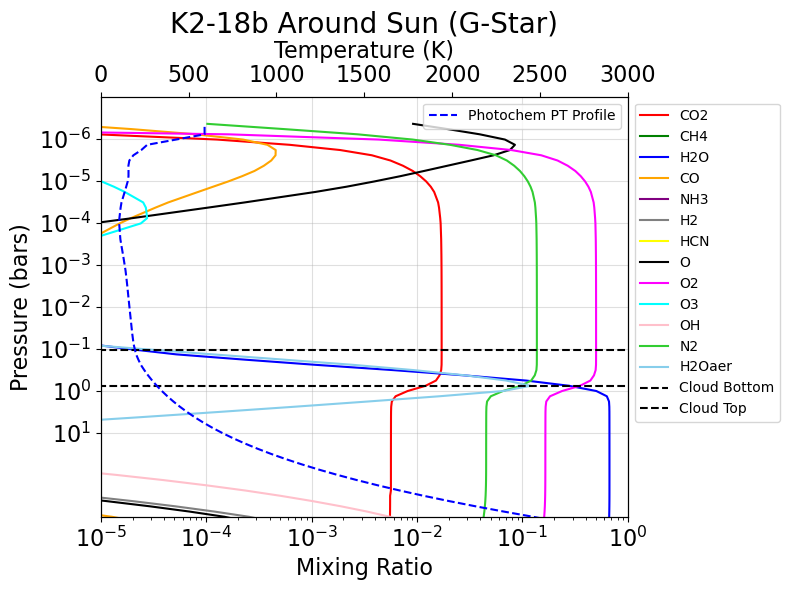

In [37]:
plot_photochem_model_with_cloud(sol=photochem_data_1000m_001co_sol, soleq=photochem_data_1000m_001co_soleq)

/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/reference/opacities/opacities_photochem_0.1_250.0_R15000.db
<class 'numpy.ndarray'>
Length of pressure vs other element: 100 vs 100
    temperature      pressure       Kzz        He             H            H2  \
0    590.864714  4.452125e-07  100000.0  0.990459  3.261463e-06  1.822635e-15   
1    590.864714  5.933751e-07  100000.0  0.979515  2.628003e-06  5.207895e-16   
2    590.864812  7.908448e-07  100000.0  0.957471  2.112926e-06  1.643961e-16   
3    427.909740  1.054031e-06  100000.0  0.917814  1.699372e-06  1.098907e-10   
4    264.247690  1.404802e-06  100000.0  0.867396  1.399484e-06  3.156047e-09   
..          ...           ...       ...       ...           ...           ...   
59   691.121564  1.022168e+01  100000.0  0.114161  2.704007e-23  5.821585e-17   
60   752.541547  1.362336e+01  100000.0  0.114130  4.455821e-21  2.197476e-15   
61   819.087054  1.815708e+01  100000.0  0

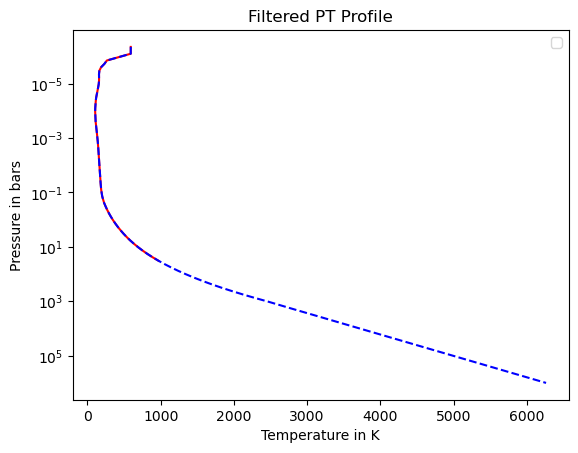

This is the length of the grids created: 483, 483
pbot was calculated, there is H2Oaer and a cloud was implemented


In [38]:
rad_plan = 2.61
log10_metal = 3
tint = 155
semi_major = 1
ctoO = 0.01
Kzz = 5
sol_path = f'sol_{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}.pkl'
soleq_path = f'soleq_{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}.pkl'
phase_angle = 0

wno_1000metal_001co, fpfs_1000metal_001co, alb_1000metal_001co, clouds_1000metal_001co = reflected_spectrum_planet_Sun(rad_plan=rad_plan, planet_metal=log10_metal, tint=tint, semi_major=semi_major, ctoO=ctoO, Kzz=Kzz, phase_angle=phase_angle, sol_path=sol_path, soleq_path=soleq_path, Photochem_file=True)

In [74]:
# Load up the earth spectra's
with open('archean_earth_res.pkl', 'rb') as file:
    res_archean_earth = pickle.load(file)

res_archean_earth

with open('modern_earth_res.pkl', 'rb') as file:
    res_modern_earth = pickle.load(file)

res_modern_earth

with open('earth_diff_phases.pkl', 'rb') as file:
    res_earth_diff_phases = pickle.load(file)
    print(res_earth_diff_phases.keys())

wv_archean = res_archean_earth['all'][0]
fpfs_archean = res_archean_earth['all'][1]
alb_archean = res_archean_earth['all'][2]
wv_modern = res_modern_earth['all'][0]
fpfs_modern = res_modern_earth['all'][1]
alb_modern = res_modern_earth['all'][2]

dict_keys(['Archean_wv_0', 'Archean_fpfs_0', 'Archean_alb_0', 'Archean_wv_0.17453293', 'Archean_fpfs_0.17453293', 'Archean_alb_0.17453293', 'Archean_wv_0.34906585', 'Archean_fpfs_0.34906585', 'Archean_alb_0.34906585', 'Archean_wv_0.52359878', 'Archean_fpfs_0.52359878', 'Archean_alb_0.52359878', 'Archean_wv_0.6981317', 'Archean_fpfs_0.6981317', 'Archean_alb_0.6981317', 'Archean_wv_0.87266463', 'Archean_fpfs_0.87266463', 'Archean_alb_0.87266463', 'Archean_wv_1.04719755', 'Archean_fpfs_1.04719755', 'Archean_alb_1.04719755', 'Archean_wv_1.22173048', 'Archean_fpfs_1.22173048', 'Archean_alb_1.22173048', 'Archean_wv_1.3962634', 'Archean_fpfs_1.3962634', 'Archean_alb_1.3962634', 'Archean_wv_1.57079633', 'Archean_fpfs_1.57079633', 'Archean_alb_1.57079633', 'Archean_wv_1.74532925', 'Archean_fpfs_1.74532925', 'Archean_alb_1.74532925', 'Archean_wv_1.91986218', 'Archean_fpfs_1.91986218', 'Archean_alb_1.91986218', 'Archean_wv_2.0943951', 'Archean_fpfs_2.0943951', 'Archean_alb_2.0943951', 'Archean_wv

2.61_0.5_155_1.04_1_5


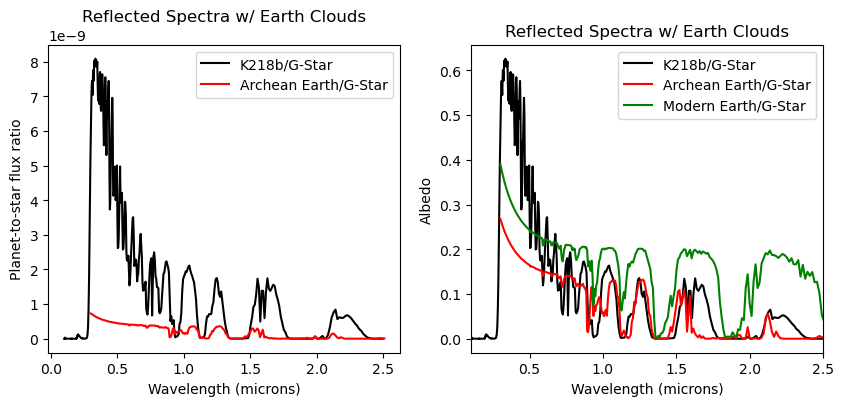

In [77]:
wno_earth = wv_archean
fpfs_earth = fpfs_archean
alb_earth = alb_archean

print(f'{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
ax1.plot(1e4/wno_1000metal_001co, fpfs_1000metal_001co, c='k', lw=1.5, label='K218b/G-Star')
ax1.plot(1e4/wno_earth, fpfs_earth, c='red', lw=1.5, label='Archean Earth/G-Star')
#ax1.set_xlim(0.3,10)
#ax1.set_ylim(0e-10,10e-10)
ax1.set_ylabel('Planet-to-star flux ratio')
ax1.set_xlabel('Wavelength (microns)')
ax1.set_title('Reflected Spectra w/ Earth Clouds')
ax1.legend()

ax2.plot(1e4/wno_1000metal_001co, alb_1000metal_001co, c='k', lw=1.5, label='K218b/G-Star')
ax2.plot(1e4/wv_archean, alb_archean/1.5, c='red', lw=1.5, label='Archean Earth/G-Star')
ax2.plot(1e4/wv_modern, alb_modern, c='green', lw=1.5, label='Modern Earth/G-Star')
ax2.set_xlim(0.1,2.5)
#ax2.set_ylim(0e-10,10e-9)
ax2.set_ylabel('Albedo')
ax2.set_xlabel('Wavelength (microns)')
ax2.set_title('Reflected Spectra w/ Earth Clouds')
ax2.legend()

#plt.savefig('Earth_K218b_clouds_RS.pdf',bbox_inches='tight')

#plt.savefig('Earth_K218b_clouds_RS_zoomedin.pdf',bbox_inches='tight')
plt.show()

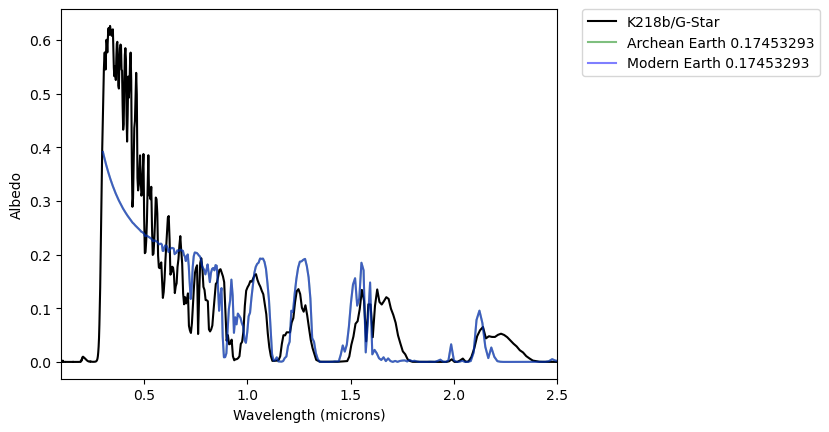

In [56]:
phase_angle_list = [0, 0.17453293, 0.34906585, 0.52359878, 0.6981317 , 
                    0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633,
                    1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095,
                    2.61799388, 2.7925268 , 2.96705973, 3.14159265]
phase_earth = phase_angle_list[:-1]

wv_archean_list = []    
fpfs_archean_list = []
alb_archean_list = []
wv_modern_list = []
fpfs_modern_list = []
alb_modern_list = []

with open('earth_diff_phases.pkl', 'rb') as file:
    earth_dict = pickle.load(file)
    for phase in phase_earth:
        for key in list(earth_dict.keys()):
            #print(f'phase: {phase}, key: {key}')
            if key.endswith(f'_{phase}'):
                if key.startswith(f'Archean_wv_'):
                    wv_archean = earth_dict[key]
                    wv_archean_list.append(wv_archean)
                if key.startswith(f'Archean_fpfs_'):
                    fpfs_archean = earth_dict[key]
                    fpfs_archean_list.append(fpfs_archean)
                if key.startswith(f'Archean_alb_'):
                    alb_archean = earth_dict[key]
                    alb_archean_list.append(alb_archean)
                if key.startswith(f'Modern_wv_'):
                    wv_modern = earth_dict[key]
                    wv_modern_list.append(wv_modern)
                if key.startswith(f'Modern_fpfs_'):
                    fpfs_modern = earth_dict[key]
                    fpfs_modern_list.append(fpfs_modern)
                if key.startswith(f'Modern_alb_'):
                    alb_modern = earth_dict[key]
                    alb_modern_list.append(alb_archean)
                    
index_earth_full = np.linspace(0, len(phase_earth) - 1, len(phase_earth), dtype='int')
index_earth = index_earth_full[1:2]
        
# Define a list of colors or use a color cycle
colors = ['green', 'blue', 'orange']
color_cycler = cycle(colors) # For cycling through colors if more data sets than colors

fig, ax = plt.subplots()
ax.plot(1e4/wno_1000metal_001co, alb_1000metal_001co, c='k', lw=1.5, label='K218b/G-Star')
ax.set_ylabel('Albedo')
ax.set_xlabel('Wavelength (microns)')
ax.set_xlim(0.1, 2.5)
for index_earth_val in index_earth:  
    ax.plot(1e4/wv_archean_list[index_earth_val], alb_archean_list[index_earth_val], c=next(color_cycler), lw=1.5, alpha=0.5, label=f'Archean Earth {phase_earth[index_earth_val]}')
    ax.plot(1e4/wv_modern_list[index_earth_val], alb_modern_list[index_earth_val], c=next(color_cycler), lw=1.5, alpha=0.5, label=f'Modern Earth {phase_earth[index_earth_val]}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Calculate the same plots but for a classically sub-neptune structur
**Parameters**:
- planet radius: 2.61x Earth 
- metallicity: 0.5x (logspace) x solar
- tint: 155K
- semi major in AU: 1.04 AU
- ctoO_solar: 1x solar c/o ratioe
- Kzz = 5 (10^5 cm^2/s)

In [40]:
sol_file_path = "sol_2.61_0.5_155_1.04_1_5.pkl"
soleq_file_path = "soleq_2.61_0.5_155_1.04_1_5.pkl"

with open(sol_file_path, 'rb') as file:
    photochem_data_05m_1co_sol = pickle.load(file)
    print(photochem_data_05m_1co_sol.keys())

with open(soleq_file_path, 'rb') as file:
    photochem_data_05m_1co_soleq = pickle.load(file)
    print(photochem_data_05m_1co_soleq.keys())

dict_keys(['pressure', 'temperature', 'Kzz', 'H2Oaer', 'CO2aer', 'NH3aer', 'N2Oaer', 'C2H2aer', 'C2H4aer', 'C2H6aer', 'CH3CNaer', 'HCCCNaer', 'HCNaer', 'CH4aer', 'He', 'H', 'H2', 'H2O', 'OH', 'O', 'O2', 'CO', 'CO2', 'HCO', 'H2CO', 'C', 'CH', 'CH2', 'CH3', 'CH4', 'CN', 'HCN', 'N', 'N2', 'NH', 'NH2', 'NH3', 'C2', 'C2H', 'C2H2', 'C2H4', 'NO', 'HNO', 'HO2', 'HNCO', 'N2O', 'H2O2', 'O3', 'NO2', 'NO3', 'HNO2', 'HNO3', 'N2H4', 'C2H6', 'CH3OH', 'CH2CO', 'CH3CHO', 'C3H4', 'C3H6', 'C4H2', 'C4H4', 'C2H3', 'C2H5', 'NCO', '1CH2', 'HCCO', 'NNH', 'CH3O', 'H2COH', 'H2CN', 'N2H2', 'C4H', 'HCNOH', 'C2H2OH', 'CH3CO', 'CH2CHO', 'C2H3OH', 'C2H4OH', 'CH3O2', 'O1D', 'N2H3', 'NH2CO', 'C4H3', 'CH2N2', 'N2D', 'CH2CN', 'CH3CN', 'HCCCN'])
dict_keys(['pressure', 'temperature', 'Kzz', 'He', 'H', 'H2', 'H2O', 'OH', 'O', 'O2', 'CO', 'CO2', 'HCO', 'H2CO', 'C', 'CH', 'CH2', 'CH3', 'CH4', 'CN', 'HCN', 'N', 'N2', 'NH', 'NH2', 'NH3', 'C2', 'C2H', 'C2H2', 'C2H4', 'NO', 'HNO', 'HO2', 'HNCO', 'N2O', 'H2O2', 'O3', 'NO2', 'NO3'

dict_keys(['H2Oaer', 'CO2aer', 'NH3aer', 'N2Oaer', 'C2H2aer', 'C2H4aer', 'C2H6aer', 'CH3CNaer', 'HCCCNaer', 'HCNaer', 'CH4aer'])


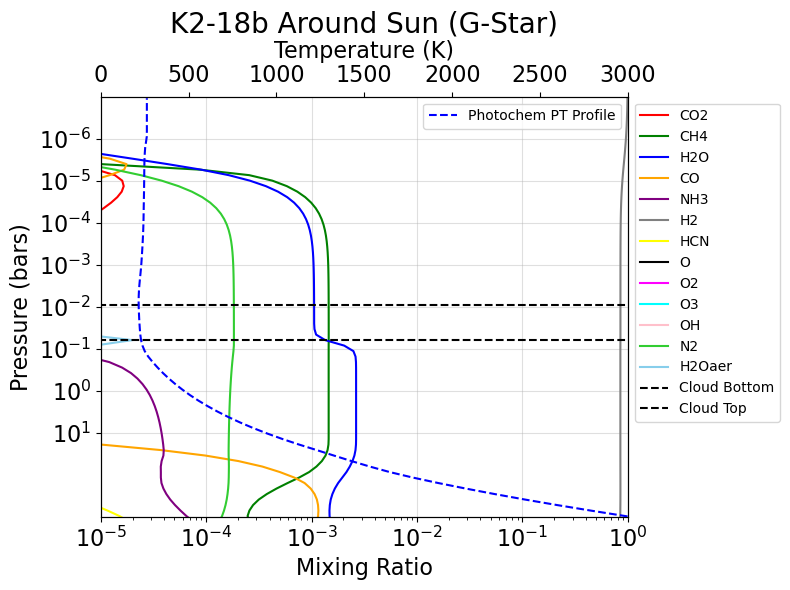

In [41]:
plot_photochem_model_with_cloud(sol=photochem_data_05m_1co_sol, soleq=photochem_data_05m_1co_soleq)

/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/reference/opacities/opacities_photochem_0.1_250.0_R15000.db
<class 'numpy.ndarray'>
Length of pressure vs other element: 100 vs 100
    temperature      pressure       Kzz        He             H        H2  \
0    262.306501  1.090871e-07  100000.0  0.008060  4.158644e-04  0.991525   
1    262.306501  1.474704e-07  100000.0  0.010164  3.611774e-04  0.989439   
2    262.306501  1.993593e-07  100000.0  0.012784  3.138797e-04  0.986851   
3    262.306501  2.695058e-07  100000.0  0.016025  2.731266e-04  0.983669   
4    262.306501  3.643339e-07  100000.0  0.019997  2.385082e-04  0.979735   
..          ...           ...       ...       ...           ...       ...   
57   664.455525  3.168645e+00  100000.0  0.145669  1.295646e-12  0.850032   
58   726.645759  4.283562e+00  100000.0  0.145670  1.235600e-12  0.850031   
59   794.291982  5.790775e+00  100000.0  0.145670  1.519517e-12  0.850030   
6

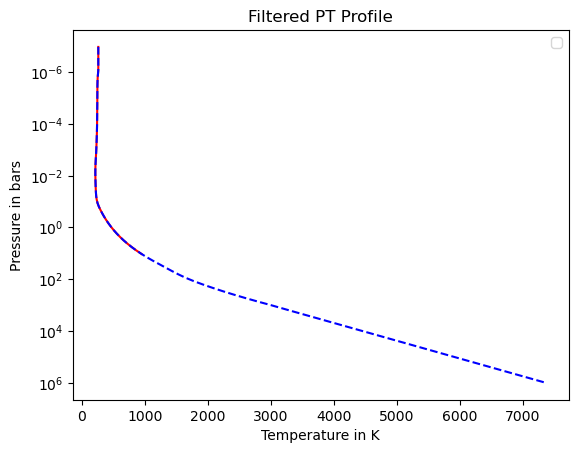

This is the length of the grids created: 483, 483
pbot was calculated, there is H2Oaer and a cloud was implemented


In [42]:
rad_plan = 2.61
log10_metal = 0.5
tint = 155
semi_major = 1.04
ctoO = 1
Kzz = 5
sol_path = f'sol_{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}.pkl'
soleq_path = f'soleq_{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}.pkl'
phase_angle = 0

wno_05metal_1co, fpfs_05metal_1co, alb_05metal_1co, clouds_05metal_1co = reflected_spectrum_planet_Sun(rad_plan=rad_plan, planet_metal=log10_metal, tint=tint, semi_major=semi_major, ctoO=ctoO, Kzz=Kzz, phase_angle=phase_angle, sol_path=sol_path, soleq_path=soleq_path, Photochem_file=True)

In [65]:
# Load up the earth spectra's
with open('archean_earth_res.pkl', 'rb') as file:
    res_archean_earth = pickle.load(file)

res_archean_earth

with open('modern_earth_res.pkl', 'rb') as file:
    res_modern_earth = pickle.load(file)

res_modern_earth

with open('earth_diff_phases.pkl', 'rb') as file:
    res_earth_diff_phases = pickle.load(file)
    print(res_earth_diff_phases.keys())

wv_archean = res_archean_earth['all'][0]
fpfs_archean = res_archean_earth['all'][1]
alb_archean = res_archean_earth['all'][2]
wv_modern = res_modern_earth['all'][0]
fpfs_modern = res_modern_earth['all'][1]
alb_modern = res_modern_earth['all'][2]

dict_keys(['Archean_wv_0', 'Archean_fpfs_0', 'Archean_alb_0', 'Archean_wv_0.17453293', 'Archean_fpfs_0.17453293', 'Archean_alb_0.17453293', 'Archean_wv_0.34906585', 'Archean_fpfs_0.34906585', 'Archean_alb_0.34906585', 'Archean_wv_0.52359878', 'Archean_fpfs_0.52359878', 'Archean_alb_0.52359878', 'Archean_wv_0.6981317', 'Archean_fpfs_0.6981317', 'Archean_alb_0.6981317', 'Archean_wv_0.87266463', 'Archean_fpfs_0.87266463', 'Archean_alb_0.87266463', 'Archean_wv_1.04719755', 'Archean_fpfs_1.04719755', 'Archean_alb_1.04719755', 'Archean_wv_1.22173048', 'Archean_fpfs_1.22173048', 'Archean_alb_1.22173048', 'Archean_wv_1.3962634', 'Archean_fpfs_1.3962634', 'Archean_alb_1.3962634', 'Archean_wv_1.57079633', 'Archean_fpfs_1.57079633', 'Archean_alb_1.57079633', 'Archean_wv_1.74532925', 'Archean_fpfs_1.74532925', 'Archean_alb_1.74532925', 'Archean_wv_1.91986218', 'Archean_fpfs_1.91986218', 'Archean_alb_1.91986218', 'Archean_wv_2.0943951', 'Archean_fpfs_2.0943951', 'Archean_alb_2.0943951', 'Archean_wv

2.61_0.5_155_1.04_1_5


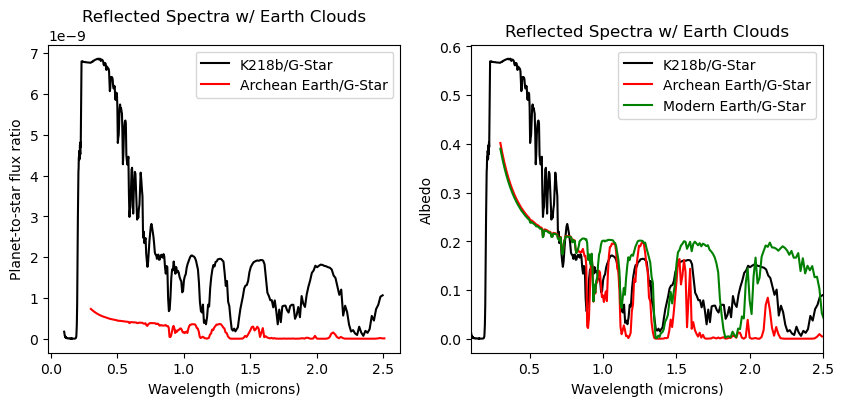

In [66]:
wno_earth = wv_archean
fpfs_earth = fpfs_archean
alb_earth = alb_archean

print(f'{rad_plan}_{log10_metal}_{tint}_{semi_major}_{ctoO}_{Kzz}')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
ax1.plot(1e4/wno_05metal_1co, fpfs_05metal_1co, c='k', lw=1.5, label='K218b/G-Star')
ax1.plot(1e4/wno_earth, fpfs_earth, c='red', lw=1.5, label='Archean Earth/G-Star')
#ax1.set_xlim(0.3,10)
#ax1.set_ylim(0e-10,10e-10)
ax1.set_ylabel('Planet-to-star flux ratio')
ax1.set_xlabel('Wavelength (microns)')
ax1.set_title('Reflected Spectra w/ Earth Clouds')
ax1.legend()

ax2.plot(1e4/wno_05metal_1co, alb_05metal_1co, c='k', lw=1.5, label='K218b/G-Star')
ax2.plot(1e4/wno_earth, alb_earth, c='red', lw=1.5, label='Archean Earth/G-Star')
ax2.plot(1e4/wv_modern, alb_modern, c='green', lw=1.5, label='Modern Earth/G-Star')
ax2.set_xlim(0.1,2.5)
#ax2.set_ylim(0e-10,10e-9)
ax2.set_ylabel('Albedo')
ax2.set_xlabel('Wavelength (microns)')
ax2.set_title('Reflected Spectra w/ Earth Clouds')
ax2.legend()

#plt.savefig('Earth_K218b_clouds_RS.pdf',bbox_inches='tight')

#plt.savefig('Earth_K218b_clouds_RS_zoomedin.pdf',bbox_inches='tight')
plt.show()

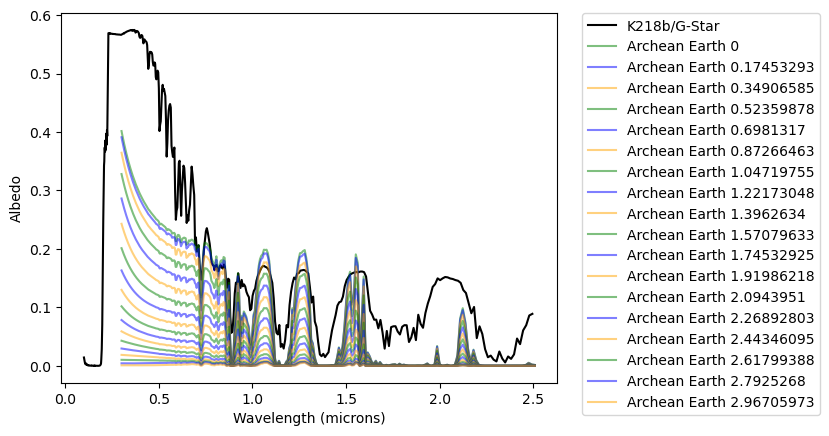

In [45]:
phase_angle_list = [0, 0.17453293, 0.34906585, 0.52359878, 0.6981317 , 
                    0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633,
                    1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095,
                    2.61799388, 2.7925268 , 2.96705973, 3.14159265]
phase_earth = phase_angle_list[:-1]

wv_archean_list = []    
fpfs_archean_list = []
alb_archean_list = []
wv_modern_list = []
fpfs_modern_list = []
alb_modern_list = []

with open('earth_diff_phases.pkl', 'rb') as file:
    earth_dict = pickle.load(file)
    for phase in phase_earth:
        for key in list(earth_dict.keys()):
            #print(f'phase: {phase}, key: {key}')
            if key.endswith(f'_{phase}'):
                if key.startswith(f'Archean_wv_'):
                    wv_archean = earth_dict[key]
                    wv_archean_list.append(wv_archean)
                if key.startswith(f'Archean_fpfs_'):
                    fpfs_archean = earth_dict[key]
                    fpfs_archean_list.append(fpfs_archean)
                if key.startswith(f'Archean_alb_'):
                    alb_archean = earth_dict[key]
                    alb_archean_list.append(alb_archean)
                if key.startswith(f'Modern_wv_'):
                    wv_modern = earth_dict[key]
                    wv_modern_list.append(wv_modern)
                if key.startswith(f'Modern_fpfs_'):
                    fpfs_modern = earth_dict[key]
                    fpfs_modern_list.append(fpfs_modern)
                if key.startswith(f'Modern_alb_'):
                    alb_modern = earth_dict[key]
                    alb_modern_list.append(alb_archean)
                    
index_earth_full = np.linspace(0, len(phase_earth) - 1, len(phase_earth), dtype='int')
index_earth = index_earth_full[::]
        
# Define a list of colors or use a color cycle
colors = ['green', 'blue', 'orange']
color_cycler = cycle(colors) # For cycling through colors if more data sets than colors

wv_earth = wv_archean_list
alb_earth = alb_archean_list

fig, ax = plt.subplots()
ax.plot(1e4/wno_05metal_1co, alb_05metal_1co, c='k', lw=1.5, label='K218b/G-Star')
ax.set_ylabel('Albedo')
ax.set_xlabel('Wavelength (microns)')
for index_earth_val in index_earth:  
    ax.plot(1e4/wv_archean_list[index_earth_val], alb_earth[index_earth_val], c=next(color_cycler), lw=1.5, alpha=0.5, label=f'Archean Earth {phase_earth[index_earth_val]}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)